In [ ]:
!pip install transformer
!pip install bert-extractive-summarizer
!pip install spacy

ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer
     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 69.3 MB/s 
     |████████████████████████████████| 3.3 MB 35.6 MB/s 
     |████████████████████████████████| 59 kB 5.2 MB/s 
     |████████████████████████████████| 895 kB 55.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from summarizer import Summarizer, TransformerSummarizer

In [ ]:
!pip3 install transformers torch sentencepiece

     |████████████████████████████████| 1.2 MB 5.5 MB/s 


## Mounting the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')     

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import time
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import  _zero_state_tensors
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 


Instructions for updating:
non-resource variables are not supported in the long term


## Insepcting the Data

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

ModuleNotFoundError: ignored

In [ ]:
reviews = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/Reviews.csv")[0:35000]

In [ ]:
reviews.shape

In [ ]:
reviews.head()

In [ ]:
# Check for any nulls values
reviews.isnull().sum()

In [ ]:
# Remove null values and unneeded features
reviews = reviews.dropna()
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator',
                        'Score','Time'], 1)
reviews = reviews.reset_index(drop=True)

In [ ]:
reviews.head()

In [ ]:
# Inspecting some of the reviews
for i in range(5):
    print("Review #",i+1)
    print(reviews.Summary[i])
    print(reviews.Text[i])
    print()

## Preprocessing

In [ ]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

We will remove the stopwords from the texts because they do not provide much use for training our model. However, we will keep them for our summaries so that they sound more like natural phrases. 

In [ ]:
import nltk
nltk.download("stopwords")

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
# Clean the summaries and texts
clean_summaries = []
for summary in reviews.Summary:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print("Summaries are complete.")

clean_texts = []
for text in reviews.Text:
    clean_texts.append(clean_text(text))
print("Texts are complete.")

In [ ]:
# Inspect the cleaned summaries and texts to ensure they have been cleaned well
for i in range(5):
    print("Clean Review #",i+1)
    print(clean_summaries[i])
    print(clean_texts[i])
    print()

In [ ]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [ ]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

count_words(word_counts, clean_summaries)
count_words(word_counts, clean_texts)
            
print("Size of Vocabulary:", len(word_counts))

In [ ]:
# Load Conceptnet Numberbatch's (CN) embeddings, similar to GloVe, but probably better 
# (https://github.com/commonsense/conceptnet-numberbatch)
embeddings_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/Datasets/numberbatch-en.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

In [ ]:
# Find the number of words that are missing from CN, and are used more than our threshold.
missing_words = 0
threshold = 20

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from CN:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

I use a threshold of 20, so that words not in CN can be added to our word_embedding_matrix, but they need to be common enough in the reviews so that the model can understand their meaning.

In [ ]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<EOS>","<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

In [ ]:
# Need to use 300 for embedding dimensions to match CN's vectors.
embedding_dim = 300
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

In [ ]:
def convert_to_ints(text, word_count, unk_count, eos=False):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in text:
        sentence_ints = []
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
        if eos:
            sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count

In [ ]:
# Apply convert_to_ints to clean_summaries and clean_texts
word_count = 0
unk_count = 0

int_summaries, word_count, unk_count = convert_to_ints(clean_summaries, word_count, unk_count)
int_texts, word_count, unk_count = convert_to_ints(clean_texts, word_count, unk_count, eos=True)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

In [ ]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [ ]:
lengths_summaries = create_lengths(int_summaries)
lengths_texts = create_lengths(int_texts)

print("Summaries:")
print(lengths_summaries.describe())
print()
print("Texts:")
print(lengths_texts.describe())

In [ ]:
# Inspect the length of texts
print(np.percentile(lengths_texts.counts, 90))
print(np.percentile(lengths_texts.counts, 95))
print(np.percentile(lengths_texts.counts, 99))

In [ ]:
# Inspect the length of summaries
print(np.percentile(lengths_summaries.counts, 90))
print(np.percentile(lengths_summaries.counts, 95))
print(np.percentile(lengths_summaries.counts, 99))

In [ ]:
def unk_counter(sentence):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [ ]:
# Sort the summaries and texts by the length of the texts, shortest to longest
# Limit the length of summaries and texts based on the min and max ranges.
# Remove reviews that include too many UNKs

sorted_summaries = []
sorted_texts = []
max_text_length = 84
max_summary_length = 13
min_length = 2
unk_text_limit = 1
unk_summary_limit = 0

for length in range(min(lengths_texts.counts), max_text_length): 
    for count, words in enumerate(int_summaries):
        if (len(int_summaries[count]) >= min_length and
            len(int_summaries[count]) <= max_summary_length and
            len(int_texts[count]) >= min_length and
            unk_counter(int_summaries[count]) <= unk_summary_limit and
            unk_counter(int_texts[count]) <= unk_text_limit and
            length == len(int_texts[count])
           ):
            sorted_summaries.append(int_summaries[count])
            sorted_texts.append(int_texts[count])
        
# Compare lengths to ensure they match
print(len(sorted_summaries))
print(len(sorted_texts))

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Datasets/Tamil_news_dataset.xlsx', header=None)
df

,0,1
0,டெல்லி: தமிழகத்திற்கு வழங்க வேண்டிய 40 டிஎம்சி...,தமிழகத்திற்கு 40 டிஎம்சி காவிரி நீரை வழங்க கர்...
1,சென்னை: சென்னையில் 2 இடங்கள் உள்பட தமிழ்நாடு ம...,சென்னையில் 2 இடங்கள் உள்பட தமிழ்நாடு முழுவதும்...
2,சென்னை : தமிழ்நாட்டில் குழந்தைகள் காப்பகங்களின...,குழந்தைகளின் பாதுகாப்பு முக்கியமானது. எந்த சூழ...
3,\nஸ்டாக்ஹாம் : 2021ம் ஆண்டு பொருளாதாரத்திற்கான...,2021ம் ஆண்டு பொருளாதாரத்துக்கான நோபல் பரிசு 3 ...
4,\nகாஞ்சிபுரம்: காஞ்சிபுரம் மாவட்டம் ஸ்ரீபெரும்...,ஸ்ரீபெரும்புதூர் அருகே துப்பாக்கியுடன் பதுங்கி...
...,...,...
495,நுகர்வோர் குழுவின் படி 'இங்கிலாந்தின் ஐந்து சி...,திருட்டு அபாயத்தில் இங்கிலாந்தின் 5 உயர்மட்ட வ...
496,400 க்கும் மேற்பட்ட தற்போதைய மற்றும் ஆன்லைன் ஊ...,பணியாளர்களாக கோரிக்கை நேரம் செலுத்திய நேரத்திற...
497,"கர்நாடக காங்கிரஸ் எம்.எல்.ஏ.க்கள் ""வரி கடந்து""...",கான் எம்.எல்.ஏக்கள் வரி கடக்கும் என்றால் வெளிய...
498,"விஸ்வா இந்து பாரிஷத் (VHP) தலைமை Vs கோக்ஜே, பி...","ராம் கோயிலில் சட்டத்தை கொண்டு வந்தால், பிஜேபி ..."


In [ ]:
ac_outputs = df[1].to_numpy()
eng_outputs = []

In [ ]:
pred_outputs = {'gpt2':[], 't5':[], 'bert': []}

In [ ]:
pip install googletrans==3.1.0a0

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 1.3 MB 9.7 MB/s 
     |████████████████████████████████| 42 kB 898 kB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 65 kB 2.6 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=6228acacb648deb1cc3817b8418a227d5cc7ca32a05713a183b07d6d2da74b5c
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [ ]:
from googletrans import Translator
import googletrans
translator = Translator()
print(googletrans.LANGUAGES)


{'af': 'afrikaans', 'sq': 'albanian', 'am': 'amharic', 'ar': 'arabic', 'hy': 'armenian', 'az': 'azerbaijani', 'eu': 'basque', 'be': 'belarusian', 'bn': 'bengali', 'bs': 'bosnian', 'bg': 'bulgarian', 'ca': 'catalan', 'ceb': 'cebuano', 'ny': 'chichewa', 'zh-cn': 'chinese (simplified)', 'zh-tw': 'chinese (traditional)', 'co': 'corsican', 'hr': 'croatian', 'cs': 'czech', 'da': 'danish', 'nl': 'dutch', 'en': 'english', 'eo': 'esperanto', 'et': 'estonian', 'tl': 'filipino', 'fi': 'finnish', 'fr': 'french', 'fy': 'frisian', 'gl': 'galician', 'ka': 'georgian', 'de': 'german', 'el': 'greek', 'gu': 'gujarati', 'ht': 'haitian creole', 'ha': 'hausa', 'haw': 'hawaiian', 'iw': 'hebrew', 'he': 'hebrew', 'hi': 'hindi', 'hmn': 'hmong', 'hu': 'hungarian', 'is': 'icelandic', 'ig': 'igbo', 'id': 'indonesian', 'ga': 'irish', 'it': 'italian', 'ja': 'japanese', 'jw': 'javanese', 'kn': 'kannada', 'kk': 'kazakh', 'km': 'khmer', 'ko': 'korean', 'ku': 'kurdish (kurmanji)', 'ky': 'kyrgyz', 'lo': 'lao', 'la': 'lat

In [ ]:
!pip install rouge

In [ ]:
inputs = df[0]

In [ ]:
gpt2 = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
bert = Summarizer()

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer


# initialize the model architecture and weights
model = T5ForConditionalGeneration.from_pretrained("t5-base")
# initialize the model tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [ ]:
def summarizer(paragraphs):
  """
    Summarizing the news article using t5 summarizer
  """
  inputs = t5_tokenizer.encode("summarize: " + paragraphs, return_tensors="pt", max_length=512, truncation=True)
  outputs = model.generate(
  inputs, 
  max_length=80, 
  min_length=20, 
  length_penalty=2.0, 
  num_beams=4, 
  early_stopping=True)
  output = t5_tokenizer.decode(outputs[0])
  return output[6:-4]

In [ ]:
pred_outputs = {'gpt2':[], 't5':[], 'bert': []}
eng_outputs = []
for item in inputs[:10]:
  tamil = item
  body = translator.translate(tamil).text
  eng_outputs.append(body)
  #gpt-2
  gpt2_summary = ''.join(gpt2(body,min_length=20))

  #bert summary
  bert_summary = ''.join(bert(body,min_length=20))

  #t5 summary
  t5_summary = ''.join(summarizer(body))

  pred_outputs['gpt2'].append(gpt2_summary)
  pred_outputs['bert'].append(bert_summary)
  pred_outputs['t5'].append(t5_summary)

In [ ]:
pred_outputs

{'bert': ['New Delhi: The Cauvery Disciplinary Committee has directed Karnataka to supply 40 TMC of Cauvery water to Tamil Nadu. Based on this, the Cauvery Disciplinary Committee has urged the Government of Karnataka to immediately open a total of 40 TMC of water.',
  "Chennai: People's Welfare Minister Ma Subramanian has said that the Kappom project camps will be held in 50 places across Tamil Nadu, including 2 places in Chennai, before tomorrow.",
  "Chennai: The High Court has directed the Tamil Nadu government to conduct periodic inspections on the status and facilities of children's archives in Tamil Nadu. The judges said that it should not be compromised under any circumstances and ordered the Tamil Nadu government to conduct periodic inspections on the status and facilities of children's homes in Tamil Nadu.",
  'Stockholm: The Nobel Prize for Economics 2021 has been announced for 3 people. The Royal Swedish Academy of Sciences has announced that the award will be presented to t

In [ ]:
from rouge import Rouge

rouge = Rouge()

In [ ]:
bert_array = pred_outputs['bert']
gpt2_array = pred_outputs['gpt2']
t5_array = pred_outputs['t5']

In [ ]:
bert_rouge = rouge.get_scores(bert_array, eng_outputs)
gpt2_rouge = rouge.get_scores(gpt2_array, eng_outputs)
t5_rouge = rouge.get_scores(t5_array, eng_outputs)

In [ ]:
bert_rouge_a = rouge.get_scores(bert_array, eng_outputs, avg=True)
gpt2_rouge_a = rouge.get_scores(gpt2_array, eng_outputs, avg=True)
t5_rouge_a = rouge.get_scores(t5_array, eng_outputs, avg=True)

In [ ]:
bert_f_rouge1 = []
bert_f_rouge2 = []
bert_f_rougel = []
for item in bert_rouge:
  bert_f_rouge1.append(item['rouge-1']['f'])
  bert_f_rouge2.append(item['rouge-2']['f'])
  bert_f_rougel.append(item['rouge-l']['f'])

In [ ]:
gpt2_f_rouge1 = []
gpt2_f_rouge2 = []
gpt2_f_rougel = []
for item in gpt2_rouge:
  gpt2_f_rouge1.append(item['rouge-1']['f'])
  gpt2_f_rouge2.append(item['rouge-2']['f'])
  gpt2_f_rougel.append(item['rouge-l']['f'])

In [ ]:
t5_f_rouge1 = []
t5_f_rouge2 = []
t5_f_rougel = []
for item in t5_rouge:
  t5_f_rouge1.append(item['rouge-1']['f'])
  t5_f_rouge2.append(item['rouge-2']['f'])
  t5_f_rougel.append(item['rouge-l']['f'])

In [ ]:
bert_f_rougel

[0.39999999680000003,
 0.4499999965125001,
 0.6034482716483354,
 0.3937007842395685,
 0.4831460637514204,
 0.5806451571696151,
 0.45333332982755553,
 0.5901639302660575,
 0.7999999952000001,
 0.5418719172316727,
 0.5283018829049484,
 0.7435897389184747,
 0.4999999962500001,
 0.4130434749834594,
 0.8181818133471075,
 0.7999999952000001,
 0.999999995,
 0.9494949445077034,
 0.6153846111242604,
 0.7999999952000001,
 0.49350648978917194,
 0.7249999953781251,
 0.46874999641113285,
 0.3488372064223905,
 0.5161290284287201,
 0.6206896508917956,
 0.41071428245057406,
 0.8539325793763415,
 0.5263157855955679,
 0.5079365041471403,
 0.4482758585909632,
 0.37037036735253775,
 0.782608690888469,
 0.6190476147732427,
 0.4778761025577571,
 0.4999999962500001,
 0.6052631536738228,
 0.4999999962500001,
 0.5773195835221597,
 0.8169014036183297,
 0.33333333055555564,
 0.47916666302300354,
 0.6306306263127993,
 0.5783132489011469,
 0.6349206305870497,
 0.39473683893698064,
 0.5806451571696151,
 0.509803917

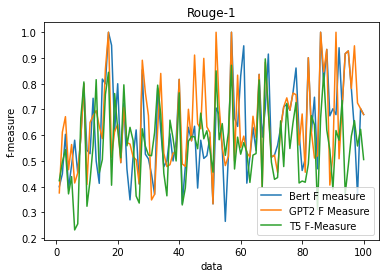

In [ ]:
import matplotlib.pyplot as plt
 
# line 1 points
x = list(range(1,101))

plt.plot(x,bert_f_rouge1, label='Bert F measure')
plt.plot(x,gpt2_f_rouge1, label='GPT2 F Measure')
plt.plot(x,t5_f_rougel, label='T5 F-Measure')
# naming the x axis
plt.xlabel('data')
# naming the y axis
plt.ylabel('f-measure')
# giving a title to my graph
plt.title('Rouge-1')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

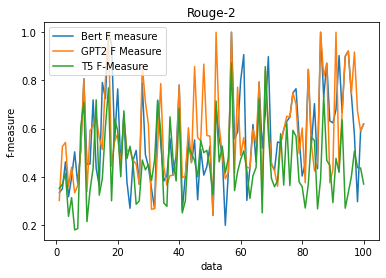

In [ ]:
import matplotlib.pyplot as plt
 
# line 1 points
x = list(range(1,101))

plt.plot(x,bert_f_rouge2, label='Bert F measure')
plt.plot(x,gpt2_f_rouge2, label='GPT2 F Measure')
plt.plot(x,t5_f_rouge2, label='T5 F-Measure')
# naming the x axis
plt.xlabel('data')
# naming the y axis
plt.ylabel('f-measure')
# giving a title to my graph
plt.title('Rouge-2')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

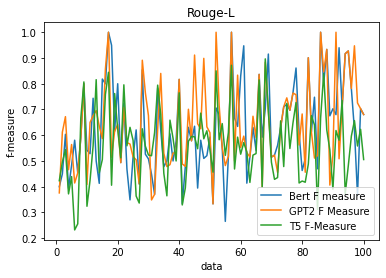

In [ ]:
import matplotlib.pyplot as plt
 
# line 1 points
x = list(range(1,101))

plt.plot(x,bert_f_rougel, label='Bert F measure')
plt.plot(x,gpt2_f_rougel, label='GPT2 F Measure')
plt.plot(x,t5_f_rougel, label='T5 F-Measure')
# naming the x axis
plt.xlabel('data')
# naming the y axis
plt.ylabel('f-measure')
# giving a title to my graph
plt.title('Rouge-L')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

In [ ]:
bert_rouge1 = bert_rouge_a['rouge-1']
gpt2_rouge1 = gpt2_rouge_a['rouge-1']
t5_rouge1 = t5_rouge_a['rouge-1']
bert_rouge1['Name'] = 'Bert'
gpt2_rouge1['Name'] = 'Gpt2'
t5_rouge1['Name'] = 'T5'

In [ ]:
pd.DataFrame([bert_rouge1, gpt2_rouge1, t5_rouge1], columns=['Name','f','p','r'])

NameError: ignored

In [ ]:
pd.DataFrame([bert_rouge2, gpt2_rouge2, t5_rouge2], columns=['Name','r','p','f'])

NameError: ignored

In [ ]:
pd.DataFrame([bert_rougel, gpt2_rougel, t5_rougel], columns=['Name','r','p','f'])